In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scraping_class
from tqdm import tqdm
from webdriver_manager.chrome import ChromeDriverManager
import requests
from selenium import webdriver
import selenium
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import time

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as mse

# Section X: Modelling

## Determining the Framework of the Model

As we are trying to predict the rating of wines based on a number of characteristics, our target parameter is continuous. As such, we wish to make a regression model and find the model that performs the best measured by having the lowest mean squared error/root mean squared error. As we are training a Machine Learning model in order to find a function that maps input variables to a target/output variable with data containing known input-output-pairs, this is a case of Supervised Machine Learning. We compare different linear models (OLS, Lasso, Ridge Regression, Elastic Net; all with Cross Validation) and optimise their hyperparameters in order to find the most accurate model for our data. 

** (Description of the different models we are going to construct and their hyperparameters) **

## Exploring our Data

In section XX we cleaned our data and it is now ready to preprocess in order to use it for modelling. The cleaned data looks like the following: 

In [235]:
df_cleaned = pd.read_csv('merged_data2.csv', index_col=0)
df_cleaned.head()

,name,rating,sub_region,year,"price, kr.",light-bold,smooth-tannic,dry-sweet,soft-acidic,winery,light-bold-cat,smooth-tannic-cat,dry-sweet-cat,soft-acidic-cat,region,kompas,kompas2
0,Zinfandel,3.5,Puglia,2019,68.00,0.650714,0.180267,0.450025,0.081305,Mammoth,semi bold,smooth,sweet,soft,Puglia,East,South-east
1,Rèmole Rosso,3.7,Toscana,2019,46.18,0.398265,0.359694,0.007172,0.423663,Frescobaldi,semi light,semi smooth,dry,semi acidic,Toscana,North,North-west
2,Pillastro Primitivo Puglia,4.0,Puglia,2019,69.00,0.654441,0.154082,0.387048,0.066308,Cantine due Palme,semi bold,smooth,semi sweet,soft,Puglia,East,South-east
3,Nero d'Avola Terre Siciliane,3.7,Terre Siciliane,2019,69.00,0.825000,0.333765,0.254032,0.195008,Massivo,bold,semi smooth,semi dry,soft,Sicilia,South,South
4,Fantini Sangiovese Terre di Chieti,3.6,Terre di Chieti,2019,84.17,0.423702,0.328743,0.065326,0.403992,Farnese,semi light,semi smooth,dry,semi soft,Abruzzo,East,East


Although our dataset is structured and cleaned for e.g. missing values, we still want to make sure that the data is ready for modelling. This includes converting some columns into dummy variables, checking data to see whether it is balanced in regards to the rating variable, detecting and removing possible outliers and inspecting the correlations between the input variables.

### Converting Columns into Dummy Variables

As we have some categorical variables in our dataset, we want to turn these into dummy variables containing binary values 0 or 1. 

**QUESTION: Should dummy variables be converted to categorical variables?**

In [239]:
dummies = pd.get_dummies(df_cleaned, columns=['region'], drop_first=True, dtype=)
df_ready = pd.concat([df_cleaned, dummies], axis=1, join='outer')
#df_ready.drop(['name', 'subregion', 'winery', 'light-bold cat', 'smooth-tannic cat', 'dry-sweet cat', 'soft-acidic cat', 'kompas', 'kompas2'], inplace=True, axis=1)
#df_ready = df_ready.iloc[:, 6:]

df_ready

TypeError: data type "category" not understood

### Statistical Information

To get started we run a simple description function to get a sense of the statistic information of the dataset: 

In [7]:
df_cleaned.describe()

,rating,year,"price, kr.",light-bold,smooth-tannic,dry-sweet,soft-acidic
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000
mean,4.156306,2011.618619,466.417087,59.778599,42.925233,16.018075,44.240954
std,0.377202,6.876600,820.950823,13.438114,17.512666,14.971164,22.164655
min,2.800000,1917.000000,11.750000,23.159000,11.232600,0.000000,0.866660
25%,3.900000,2010.000000,122.937500,49.036025,32.288225,4.087760,24.354375
50%,4.200000,2013.000000,249.000000,59.834600,39.371750,10.257050,42.340550
75%,4.500000,2016.000000,495.000000,66.941950,53.829775,25.211500,61.699125
max,4.900000,2019.000000,11500.000000,82.500000,82.500000,58.649100,82.500000


In the above table we see that we have that the description is only made for the numerical columns, and as mentioned we will start of by using some of these and then include more and more in our model as we go along. 

We see that we have a total of XXXX rows in the dataset and hence XXXX observations. We start by looking at one column at a time. 

In the '*rating*' column we see that the mean rating is ~4.16 with a standard deviation of ~0.38. This is a fairly high average rating. We also see that the 1st quantile is 3.9 and we can conclude that most wines in the Vivino.com network has a high rating. 

For the '*year*' column we see that the years of the wine is spread from 1917 up until 2019. However, as the mean year is around 2011, we might have to check whether there are som outliers that a worth removing from our dataset before we begin modelling. 

In the '*price, kr.*' column we inspect the prices of the wines. Here we see that the prices span from just 11 kr. to 11.500. As the mean is ~466 kr. and the standard deviation is ~821, the minimum value seems resonible (although that's a very cheap red wine, **more on that in the discussion of the data quality later**), but the maximum value of 11.500 kr. seems like an outlier and we will have to check whether some of these high prices should be removed. 

For the four last columns with the taste characteristics we see that all values span from 0% to 82.5%. This was expected as the numbers represent percentages, however there seems to be a static upper cap on the maximum values. Inspecting the Vivino.com site we see that it looks like there is indeed a maximum cap of how high the percentages can get (**more on that in the discussion of the data quality later**). 

### Detecting Outliers

In order to detect possible outliers in our dataset, we start by making boxplots of the different variables in order to get a better insight of the distribution of the values in the columns. 

Text(0.5, 0, '')

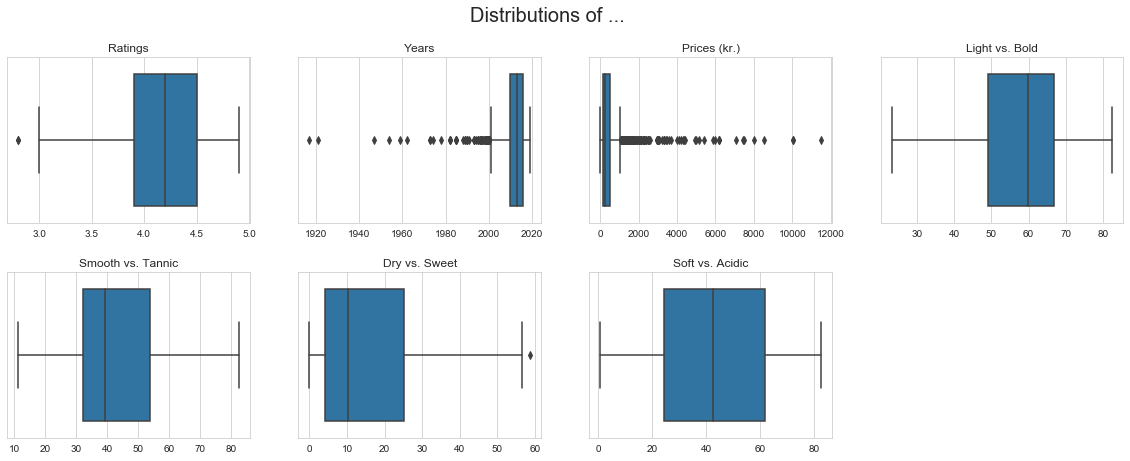

In [128]:
fig, ax = plt.subplots(2, 4, figsize=(20,7))
fig.delaxes(ax[1,3]) # Removing the 8th subplot
fig.subplots_adjust(hspace=0.3) # Adding space between rows
sns.set_style("whitegrid")
fig.suptitle('Distributions of ...', fontsize=20)

bp1 = sns.boxplot(df_cleaned['rating'], ax=ax[0][0])
bp2 = sns.boxplot(df_cleaned['year'], ax=ax[0][1])
bp3 = sns.boxplot(df_cleaned['price, kr.'], ax=ax[0][2])
bp4 = sns.boxplot(df_cleaned['light-bold'], ax=ax[0][3])
bp5 = sns.boxplot(df_cleaned['smooth-tannic'], ax=ax[1][0])
bp6 = sns.boxplot(df_cleaned['dry-sweet'], ax=ax[1][1])
bp7 = sns.boxplot(df_cleaned['soft-acidic'], ax=ax[1][2])

ax[0][0].set_title('Ratings')
ax[0][1].set_title('Years')
ax[0][2].set_title('Prices (kr.)')
ax[0][3].set_title('Light vs. Bold')
ax[1][0].set_title('Smooth vs. Tannic')
ax[1][1].set_title('Dry vs. Sweet')
ax[1][2].set_title('Soft vs. Acidic')

ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[0][2].set_xlabel('')
ax[0][3].set_xlabel('')
ax[1][0].set_xlabel('')
ax[1][1].set_xlabel('')
ax[1][2].set_xlabel('')

From the above we see that most of the values are evenly spread for the different variables. However, the '*year*' and '*price, kr.*' variables have a lot of outliers in the left and right part of the boxplots respectively. We see that most of the wines are produced between 2000 and 2019 at a price levet from 0 kr. to ~1400 kr. The values outside these limits seem to be outliers. 

In order to streamline the data and get the best performance of the machine learning model, we want to remove these outliers. At first we examine how many outliers we have in order to check whether it is wise to remove them. 

In [231]:
print('There are', len(df_cleaned), 'observations in total.')
print()
print('There are', np.count_nonzero(df_cleaned['year']<2000), 'observations before year 2000, which corresponds to',
     round(np.count_nonzero(df_cleaned['year']<2000)/len(df_cleaned)*100,1), '% of the data.')
print()
print('There are', np.count_nonzero(df_cleaned['price, kr.']>1400), 'observations with a price above 1400 kr., which corresponds to',
     round(np.count_nonzero(df_cleaned['price, kr.']>1400)/len(df_cleaned)*100,1), '% of the data.')
print()
print('There are', np.count_nonzero(np.logical_or(df_cleaned['year']<2000, df_cleaned['price, kr.']>1400)), 'observations before year 2000 OR with a price above 1400 kr., which corresponds to',
     round(np.count_nonzero(np.logical_or(df_cleaned['year']<2000, df_cleaned['price, kr.']>1400))/len(df_cleaned)*100,1), '% of the data.')

There are 1998 observations in total.

There are 97 observations before year 2000, which corresponds to 4.9 % of the data.

There are 106 observations with a price above 1400 kr., which corresponds to 5.3 % of the data.

There are 172 observations before year 2000 OR with a price above 1400 kr., which corresponds to 8.6 % of the data.


From the above we see that removing the outliers in columns '*year*' and '*price, kr.*' will only remove 8.6% of our observations and as so we remove them. We now use the *z*-score in order to correctly find and remove the true outliers. To find the *z*-scores we take each observation value, subtract the mean and divide this by the standard deviation. As such, the score tells us how many standard deviations the observation value is from the mean. Mathematically the *z*-score is defined as follows: 
\begin{align}
z = \frac{X-\mu}{\sigma} \\
\end{align}

We calculate the *z*-score for each observation and characterise an observation as an outlier it the *z*-score of that observation is greater than 3 or less than -3. We use 3 as threshold based on the empirical rule. 

**Kilder**: 

https://en.wikipedia.org/wiki/Standard_score 

https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule 

In [233]:
# Outliers in the 'price, kr.' column
threshold = 3
outliers_price = [] 
mean_price = df_cleaned['price, kr.'].values.mean()
std_price = df_cleaned['price, kr.'].values.std() 
for x in df_cleaned['price, kr.'].values:
    z = (x-mean_price)/std_price
    if abs(z) > threshold: 
        outliers_price.append(x) 
outliers_price = sorted(outliers_price)
print('The outliers in the "price, kr." column are:\n', outliers_price, '\nNumber of outliers:', len(outliers_price))

The outliers in the "price, kr." column are:
 [2942.18, 2942.18, 2971.98, 2992.09, 3017.41, 3053.91, 3071.09, 3240.12, 3314.98, 3314.98, 3314.98, 3314.98, 3414.43, 3491.51, 3595.0, 3682.57, 4022.22, 4078.79, 4196.36, 4317.18, 4373.0, 4431.89, 4958.33, 5000.0, 5165.2, 5396.48, 5888.67, 5993.71, 6167.41, 6167.41, 6167.41, 7058.25, 7448.56, 7500.0, 8007.2, 8542.5, 10022.04, 10022.04, 11500.0] 
Number of outliers: 39


In [232]:
# Outliers in the 'year' column
threshold = 3
outliers_year = [] 
mean_year = df_cleaned['year'].values.mean()
std_year = df_cleaned['year'].values.std() 
for x in df_cleaned['year'].values:
    z = (x-mean_year)/std_year
    if abs(z) > threshold: 
        outliers_year.append(x) 
outliers_year = sorted(outliers_year)
print('The outliers in the "year" column are:\n', outliers_year, '\nNumber of outliers:', len(outliers_year))

The outliers in the "year" column are:
 [1917, 1921, 1947, 1954, 1959, 1962, 1973, 1973, 1974, 1978, 1982, 1982, 1982, 1985, 1985, 1985, 1985, 1988, 1989, 1989, 1989, 1990, 1990, 1990, 1990] 
Number of outliers: 25


As we see from the above calculations, we were a bit harsh on the range of outliers as we now "only" have 39 and 25 outliers for price and year respectively. We will now remove these outliers from out dataset. 

### Inspecting Correlations

## Applying Supervised Machine Learning

To begin with we are unaware which features effect the ratings of the wines. Therefore, we start our model simply by predicting the rating based on the price of the wine and then build from there into a more complicated and hopefully accurate model. 
First, we plot the price against the rating for our data and see if we can detect patterns or the likes. 

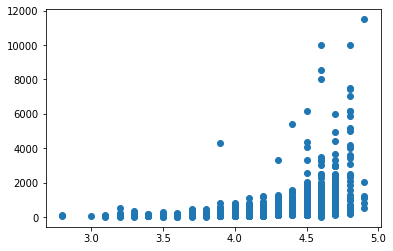

In [25]:
fig = plt.scatter(df_cleaned['rating'], df_cleaned['price, kr.']) 
fig

In [ ]:
# Splitting the data in target and data (y and x)
y = df_ready.rating.to_numpy()
X = df_ready.drop(['rating'],axis=1) 